# Optimizing a GAN for galaxy sample 

In [15]:
import tensorflow as tf
from tensorflow import keras
import h5py
import matplotlib.pyplot as plt
import os
import time
from IPython import display

In [16]:
noise_dim = 100
num_examples_to_generate = 16
outputdir = './outputs/'
seed = tf.random.normal([num_examples_to_generate, noise_dim])

hf = h5py.File('Sample.hdf5', 'r')
train_images, train_labels = hf['train_img'], hf['train_labels']
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(5000).batch(64)

In [17]:
## test architecture not yet fully optimized - GPU functionality missing
def generator():

    model = tf.keras.Sequential([
    tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Reshape((7, 7, 256)),

    tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
        
    return model

def discriminator():
    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.1), #regularization - small fraction due to limited training

    tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
    ])

    return model

gen = generator()
discrim = discriminator()

In [18]:
ce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# the generator and discriminator loss functions
def discrim_loss(out1, out2):
    l1 = ce(tf.ones_like(out1), out1)
    l2 = ce(tf.zeros_like(out2), out2)
    tot = l1 + l2
    return tot

def gen_loss(out):
    return ce(tf.ones_like(out), out)

opt1 = tf.keras.optimizers.Adam()
opt2 = tf.keras.optimizers.Adam()
checkpoint = tf.train.Checkpoint(generator_optimizer=opt1, discriminator_optimizer=opt2, generator=gen, discriminator=discrim)

In [19]:
@tf.function
def train_step(images):
    noise = tf.random.normal([64, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gen(noise, training=True)

        out1 = discrim(images, training=True)
        out2 = discrim(generated_images, training=True)
        gloss = gen_loss(out2)
        dloss = discrim_loss(out1, out2)

    gradients_of_gen = gen_tape.gradient(gloss, gen.trainable_variables)
    gradients_of_discrim = disc_tape.gradient(dloss, discrim.trainable_variables)
    opt1.apply_gradients(zip(gradients_of_gen, gen.trainable_variables))
    opt2.apply_gradients(zip(gradients_of_discrim, discrim.trainable_variables))

In [20]:
# GPU with TensorFlow 2 on Ubuntu linux is malfunctioning; not easy to optimize on CPU alone - hence basic first pass alone noise maps
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)

        predicted_image = gen(seed, training=False)        
        for i in range(predicted_image.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(predicted_image[i, :, :, 0])
            plt.axis('off')
        plt.savefig(outputdir+'image_at_epoch_{:04d}.png'.format(epoch + 1))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = os.path.join(outputdir, "ckpt"))

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

Time for epoch 1 is 19.797429084777832 sec


/Users/hooshang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


Time for epoch 2 is 16.77232599258423 sec
Time for epoch 3 is 17.031827926635742 sec
Time for epoch 4 is 16.84370994567871 sec
Time for epoch 5 is 17.13599419593811 sec
Time for epoch 6 is 16.99045419692993 sec
Time for epoch 7 is 17.099609851837158 sec
Time for epoch 8 is 17.104710340499878 sec
Time for epoch 9 is 17.026900053024292 sec
Time for epoch 10 is 17.025132179260254 sec
Time for epoch 11 is 17.214664936065674 sec
Time for epoch 12 is 18.442803859710693 sec
Time for epoch 13 is 17.271920919418335 sec
Time for epoch 14 is 17.206044912338257 sec
Time for epoch 15 is 17.6421160697937 sec
Time for epoch 16 is 17.21672773361206 sec
Time for epoch 17 is 17.985862016677856 sec
Time for epoch 18 is 17.832012176513672 sec
Time for epoch 19 is 17.554195880889893 sec
Time for epoch 20 is 17.612322092056274 sec
Time for epoch 21 is 17.315730810165405 sec
Time for epoch 22 is 17.41260313987732 sec
Time for epoch 23 is 18.37669086456299 sec
Time for epoch 24 is 19.37917685508728 sec
Time f

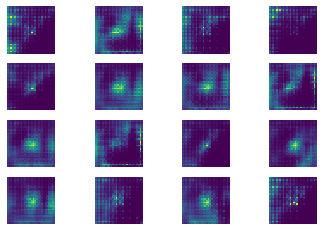

In [21]:
%%time
train(train_dataset, 50) #using 50 epochs - need much higher for optimization with GPU
